Question 3 Code:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import spectral
import seaborn as sns
import tensorflow as tf
import keras
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from keras.layers import Dropout, Input
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from operator import truediv
from scipy.io import loadmat
from plotly.offline import init_notebook_mode
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

Loading The Data

In [2]:
X=loadmat('D:/FAST_NUCES/7thSemester/DLP/Assignment/Assignment3/Datasets/DatasetQ3/PaviaU.mat')['paviaU'] #the actual file 
y=loadmat('D:/FAST_NUCES/7thSemester/DLP/Assignment/Assignment3/Datasets/DatasetQ3/PaviaU_gt.mat')['paviaU_gt'] #ground truth file - for the semantic segmentation

Preprocessing + Applying PCA + Zero Padding 

In [6]:
pixelsize=25
test_split_ratio=0.8
X.shape, y.shape
K=X.shape[2]
print(K)

103


In [7]:
#Finding the PCA
numComponents=15
tempX = np.reshape(X, (-1, X.shape[2]))
pca = PCA(n_components=numComponents, whiten=True)
tempX = pca.fit_transform(tempX)
tempX = np.reshape(tempX, (X.shape[0],X.shape[1], numComponents))
X = tempX
X.shape

(610, 340, 15)

In [8]:
#Applying Zero Padding
def ZerosPadding(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [3]:
#Splitting The Image into Cubes
def CubeSplit(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = ZerosPadding(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [10]:
X, y = CubeSplit(X, y, windowSize=25)

X.shape, y.shape

((42776, 25, 25, 15), (42776,))

In [11]:
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

In [12]:
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X, y, test_split_ratio)

Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((8555, 25, 25, 15), (34221, 25, 25, 15), (8555,), (34221,))

In [13]:
Xtrain, Xvalid, ytrain, yvalid = splitTrainTestSet(Xtrain, ytrain, 0.2)

Xtrain.shape, Xvalid.shape, ytrain.shape, yvalid.shape

((6844, 25, 25, 15), (1711, 25, 25, 15), (6844,), (1711,))

In [14]:
Xtrain = Xtrain.reshape(-1, pixelsize, pixelsize, 15, 1)
print(Xtrain.shape)
ytrain = np_utils.to_categorical(ytrain)
ytrain.shape

(6844, 25, 25, 15, 1)


(6844, 9)

In [15]:
Xvalid = Xvalid.reshape(-1, pixelsize, pixelsize, 15, 1) 
print(Xvalid.shape)
yvalid=np_utils.to_categorical(yvalid)
yvalid.shape

(1711, 25, 25, 15, 1)


(1711, 9)

In [16]:
input_layer=Input((25,25,15,1))
conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 7), activation='relu')(input_layer)
conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 5), activation='relu')(conv_layer1)
conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(conv_layer2)
print(conv_layer3.shape)
conv3d_shape = conv_layer3.shape
conv_layer3 = Reshape((conv3d_shape[1], conv3d_shape[2], conv3d_shape[3]*conv3d_shape[4]))(conv_layer3)
conv_layer4 = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(conv_layer3)
flatten_layer = Flatten()(conv_layer4)
dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.4)(dense_layer2)
output_layer = Dense(units=9, activation='softmax')(dense_layer2)

(None, 19, 19, 3, 32)


In [17]:
model=Model(inputs=input_layer,outputs=output_layer)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 25, 25, 15, 1)]   0         
                                                                 
 conv3d (Conv3D)             (None, 23, 23, 9, 8)      512       
                                                                 
 conv3d_1 (Conv3D)           (None, 21, 21, 5, 16)     5776      
                                                                 
 conv3d_2 (Conv3D)           (None, 19, 19, 3, 32)     13856     
                                                                 
 reshape (Reshape)           (None, 19, 19, 96)        0         
                                                                 
 conv2d (Conv2D)             (None, 17, 17, 64)        55360     
                                                                 
 flatten (Flatten)           (None, 18496)             0     

In [18]:
adam=Adam(learning_rate=0.001)
model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])

In [19]:
filepath = "best-model.hdf5"
metric='acc'
checkpoint=ModelCheckpoint(filepath=filepath,monitor=metric,verbose=1,save_best_only=True,mode='max')
callback_list=[checkpoint]

In [20]:
history=model.fit(x=Xtrain,y=ytrain,validation_data=(Xvalid,yvalid),batch_size=256,epochs=10,callbacks=callback_list)

Epoch 1/10
27/27 [==============================] - 22s 799ms/step - loss: 1.1722 - accuracy: 0.5919 - val_loss: 0.4848 - val_accuracy: 0.8212
Epoch 2/10
27/27 [==============================] - 21s 781ms/step - loss: 0.3294 - accuracy: 0.8929 - val_loss: 0.1447 - val_accuracy: 0.9573
Epoch 3/10
27/27 [==============================] - 21s 781ms/step - loss: 0.0986 - accuracy: 0.9718 - val_loss: 0.0526 - val_accuracy: 0.9901
Epoch 4/10
27/27 [==============================] - 21s 781ms/step - loss: 0.0507 - accuracy: 0.9860 - val_loss: 0.0312 - val_accuracy: 0.9930
Epoch 5/10
27/27 [==============================] - 21s 785ms/step - loss: 0.0371 - accuracy: 0.9885 - val_loss: 0.0237 - val_accuracy: 0.9906
Epoch 6/10
27/27 [==============================] - 21s 784ms/step - loss: 0.0260 - accuracy: 0.9917 - val_loss: 0.0080 - val_accuracy: 0.9982
Epoch 7/10
27/27 [==============================] - 21s 785ms/step - loss: 0.0183 - accuracy: 0.9955 - val_loss: 0.0106 - val_accuracy: 0.9959

In [21]:
model.save("best-model1.hdf5")

In [24]:
model.load_weights=("best-model1.hdf5")
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [25]:
Xtest=Xtest.reshape(-1,pixelsize,pixelsize,15,1)
print(Xtest.shape)
ytest=np_utils.to_categorical(ytest)
print(ytest.shape)

(29944, 25, 25, 15, 1)
(29944, 9)


In [26]:
Y_pred_test=model.predict(Xtest)
Y_pred_test=np.argmax(Y_pred_test,axis=1)
classification= classification_report(np.argmax(ytest,axis=1),Y_pred_test)
classification

936/936 [==============================] - 104s 109ms/step


'              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00      4642\n           1       1.00      1.00      1.00     13055\n           2       0.99      1.00      1.00      1469\n           3       1.00      0.99      1.00      2145\n           4       1.00      1.00      1.00       942\n           5       1.00      1.00      1.00      3520\n           6       1.00      1.00      1.00       931\n           7       0.99      1.00      1.00      2577\n           8       0.99      1.00      0.99       663\n\n    accuracy                           1.00     29944\n   macro avg       1.00      1.00      1.00     29944\nweighted avg       1.00      1.00      1.00     29944\n'

In [27]:
print(classification)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4642
           1       1.00      1.00      1.00     13055
           2       0.99      1.00      1.00      1469
           3       1.00      0.99      1.00      2145
           4       1.00      1.00      1.00       942
           5       1.00      1.00      1.00      3520
           6       1.00      1.00      1.00       931
           7       0.99      1.00      1.00      2577
           8       0.99      1.00      0.99       663

    accuracy                           1.00     29944
   macro avg       1.00      1.00      1.00     29944
weighted avg       1.00      1.00      1.00     29944



In [28]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter= confusion_matrix[0]
    list_diag= np.diag(confusion_matrix)
    list_raw_sum= np.sum(confusion_matrix,axis=1)
    each_acc=np.nan_to_num(truediv(list_diag,list_raw_sum))
    average_acc=np.mean(each_acc)
    return each_acc, average_acc

In [29]:
import time 
def reports(X_test,y_test,name):
    start=time.time()
    Y_pred=model.predict(X_test)
    y_pred=np.argmax(Y_pred,axis=1)
    end=time.time()
    print(end-start)
    target_names=['Asphalt','Meadows','Gravel','Trees','Painted metal sheets','Bare Soil','Bitumen','Self-Blocking Bricks','Shadows']
    classification=classification_report(np.argmax(y_test,axis=1),y_pred,target_names=target_names)
    oa=accuracy_score(np.argmax(y_test,axis=1),y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100
    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100

In [50]:
#DONT DO THIS - print it test and overall acc
import os 
classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(Xtest,ytest,dataset)
classification = str(classification)
confusion = str(confusion)
file_name = "classification_report.txt"

with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

936/936 [==============================] - 98s 105ms/step
110.46565771102905
936/936 [==============================] - 93s 97ms/step - loss: 0.0111 - accuracy: 0.9974


In [30]:
def Patch(data,height_index,width_index):
    height_slice=slice(height_index,height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    
    return patch

This point on the pixel by pixel image segmentation happening here 

In [31]:
X=loadmat('G:\FAST\Semester 7\Deep Learning\Assignments\Assignment 3\q3_dataset/PaviaU.mat')['paviaU']
y=loadmat('G:\FAST\Semester 7\Deep Learning\Assignments\Assignment 3\q3_dataset/PaviaU_gt.mat')['paviaU_gt']

height=y.shape[0]
weidth=y.shape[1]
PATCH_SIZE=25
numComponents=15

In [32]:
X,pca=applyPCA(X,numComponents=numComponents)
X=padWithZeros(X,PATCH_SIZE//2)

In [33]:
outputs=np.zeros((height,weidth))
for i in range (height):
    for j in range (weidth):
        target=int(y[i,j])
        if target==0:
            continue
        else:
            image_patch=Patch(X,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')                                   
            prediction=(model.predict(X_test_image))
            prediction=np.argmax(prediction,axis=1)
            outputs[i][j]=prediction+1

1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 59ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 54ms/step


1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 57ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 63ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 61ms/step


1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 54ms/step


1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 54ms/step


1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 57ms/step


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 60ms/step


1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 54ms/step


1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 59ms/step


1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 60ms/step


1/1 [==============================] - 0s 75ms/step


1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 54ms/step


1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 57ms/step


1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 56ms/step


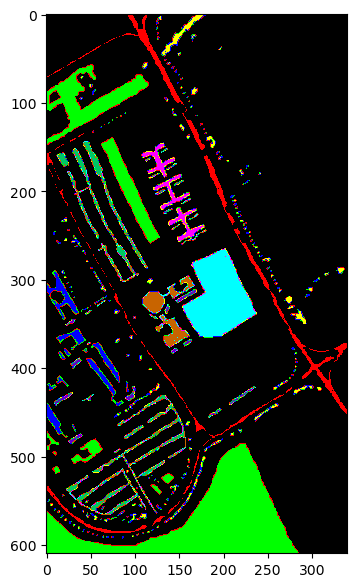

In [34]:
ground_truth = spectral.imshow(classes = y,figsize =(7,7))

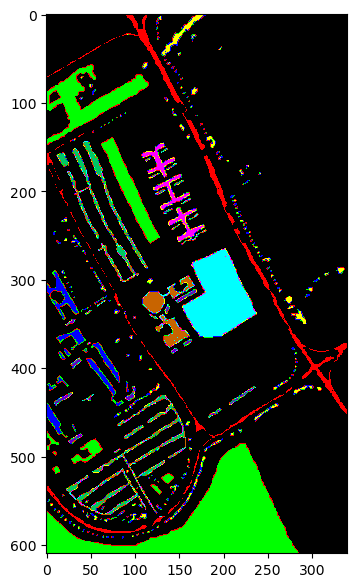

In [35]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))

In [36]:
conf_matrix = confusion_matrix(np.argmax(ytest, axis=1), Y_pred_test)

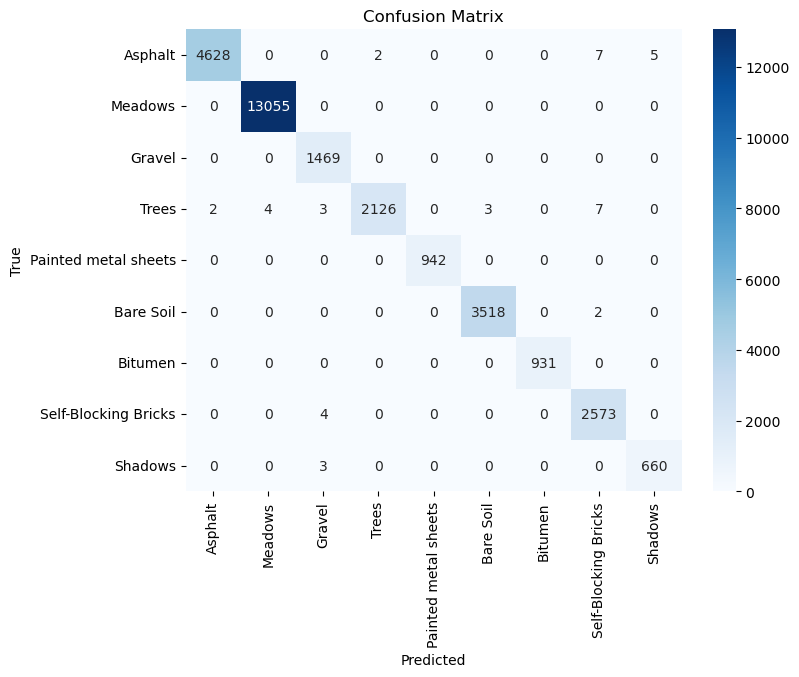

In [37]:
classes = ['Asphalt', 'Meadows', 'Gravel', 'Trees', 'Painted metal sheets',
            'Bare Soil', 'Bitumen', 'Self-Blocking Bricks', 'Shadows']
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()